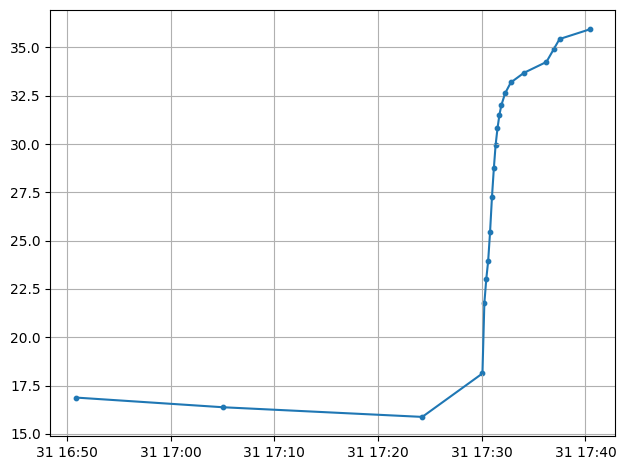

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("teplota_log.csv", header=None, names=["Time", "Value"])
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna().sort_values("Time").drop_duplicates("Time")

df_plot = df[df["Time"] >= df["Time"].max() - pd.Timedelta(hours=1)]

plt.plot(df_plot["Time"], df_plot["Value"])
plt.scatter(df_plot["Time"], df_plot["Value"], s=10)
plt.grid()
plt.tight_layout()
plt.show()


In [31]:
 
df_plot.tail(20)


,Time,Value
900,2026-01-31 17:05:03,16.375
901,2026-01-31 17:24:16,15.875
902,2026-01-31 17:30:04,18.125
903,2026-01-31 17:30:15,21.750
904,2026-01-31 17:30:26,23.000
905,2026-01-31 17:30:37,23.937
906,2026-01-31 17:30:48,25.437
907,2026-01-31 17:30:59,27.250
908,2026-01-31 17:31:10,28.750
909,2026-01-31 17:31:20,29.937


In [32]:
import pandas as pd

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/Weather.csv"

# Přeskočíme prvních 5 řádků, kde nejsou data
df_netatmo = pd.read_csv(path, skiprows=5)

# Oprava názvů sloupců
df_netatmo.columns = ["timestamp", "time_str", "temperature", "humidity", "empty"]

# Odstranění prázdného sloupce
df_netatmo = df_netatmo.drop(columns=["empty"])

# Převod timestamp → datetime
df_netatmo["time_utc"] = pd.to_datetime(df_netatmo["timestamp"], unit="s")

# Převod textového času → datetime
df_netatmo["time_local"] = pd.to_datetime(df_netatmo["time_str"])

df_netatmo


,timestamp,time_str,temperature,humidity,time_utc,time_local
0,1767222150,2026/01/01 00:02:30,1.5,86,2025-12-31 23:02:30,2026-01-01 00:02:30
1,1767222450,2026/01/01 00:07:30,1.5,86,2025-12-31 23:07:30,2026-01-01 00:07:30
2,1767222750,2026/01/01 00:12:30,1.5,86,2025-12-31 23:12:30,2026-01-01 00:12:30
3,1767223050,2026/01/01 00:17:30,1.6,86,2025-12-31 23:17:30,2026-01-01 00:17:30
4,1767223350,2026/01/01 00:22:30,1.6,86,2025-12-31 23:22:30,2026-01-01 00:22:30
...,...,...,...,...,...,...
6946,1769425800,2026/01/30 8:20:00,0.1,95,2026-01-26 11:10:00,2026-01-30 08:20:00
6947,1769425800,2026/01/30 13:00:00,2.6,95,2026-01-26 11:10:00,2026-01-30 13:00:00
6948,1769425800,2026/01/31 7:55:00,-0.5,95,2026-01-26 11:10:00,2026-01-31 07:55:00
6949,1769425800,2026/01/31 14:05:00,2.0,95,2026-01-26 11:10:00,2026-01-31 14:05:00


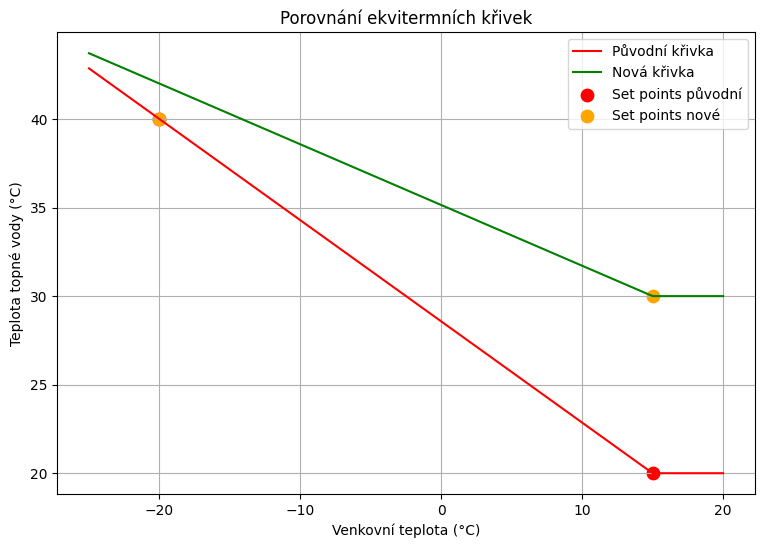

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# Nová křivka podle bodů A(-20/42) a B(15/30)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30


# Data pro graf
temps_in = np.linspace(-25, 20, 200)
temps_out_1 = [hokejka(t) for t in temps_in]
temps_out_2 = [hokejka2(t) for t in temps_in]

# Vykreslení
plt.figure(figsize=(9, 6))
plt.plot(temps_in, temps_out_1, label="Původní křivka", color="red")
plt.plot(temps_in, temps_out_2, label="Nová křivka", color="green")

# Body původní křivky
plt.scatter([-20, 15], [40, 20], color="red", s=80, label="Set points původní")

# Body nové křivky
plt.scatter([-20, 15], [40, 30], color="orange", s=80, label="Set points nové")

plt.title("Porovnání ekvitermních křivek")
plt.xlabel("Venkovní teplota (°C)")
plt.ylabel("Teplota topné vody (°C)")
plt.grid(True)
plt.legend()

# Uložení grafu
plt.savefig("Equit_graf.png")

plt.show()




In [34]:
import pandas as pd

# Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# Nová křivka podle bodů A(-20/40) a B(15/30)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# Sloupec Boiler_water
df_netatmo["Boiler_water"] = df_netatmo["temperature"].apply(hokejka)

# Nový sloupec Boiler_water_2
df_netatmo["Boiler_water_2"] = df_netatmo["temperature"].apply(hokejka2)

# Ukázka posledních 10 řádků
df_netatmo.tail(10)


,timestamp,time_str,temperature,humidity,time_utc,time_local,Boiler_water,Boiler_water_2
6941,1769425800,2026/01/29 11:40:00,1.0,95,2026-01-26 11:10:00,2026-01-29 11:40:00,27.999972,34.800143
6942,1769425800,2026/01/29 13:50:00,2.0,95,2026-01-26 11:10:00,2026-01-29 13:50:00,27.428544,34.457286
6943,1769425800,2026/01/29 14:30:00,2.0,95,2026-01-26 11:10:00,2026-01-29 14:30:00,27.428544,34.457286
6944,1769425800,2026/01/29 18:00:00,0.6,95,2026-01-26 11:10:00,2026-01-29 18:00:00,28.228543,34.937286
6945,1769425800,2026/01/29 23:30:00,0.4,95,2026-01-26 11:10:00,2026-01-29 23:30:00,28.342829,35.005857
6946,1769425800,2026/01/30 8:20:00,0.1,95,2026-01-26 11:10:00,2026-01-30 08:20:00,28.514257,35.108714
6947,1769425800,2026/01/30 13:00:00,2.6,95,2026-01-26 11:10:00,2026-01-30 13:00:00,27.085687,34.251572
6948,1769425800,2026/01/31 7:55:00,-0.5,95,2026-01-26 11:10:00,2026-01-31 07:55:00,28.857114,35.314428
6949,1769425800,2026/01/31 14:05:00,2.0,95,2026-01-26 11:10:00,2026-01-31 14:05:00,27.428544,34.457286
6950,1769425800,2026/01/31 17:25:00,-0.2,95,2026-01-26 11:10:00,2026-01-31 17:25:00,28.685686,35.211571


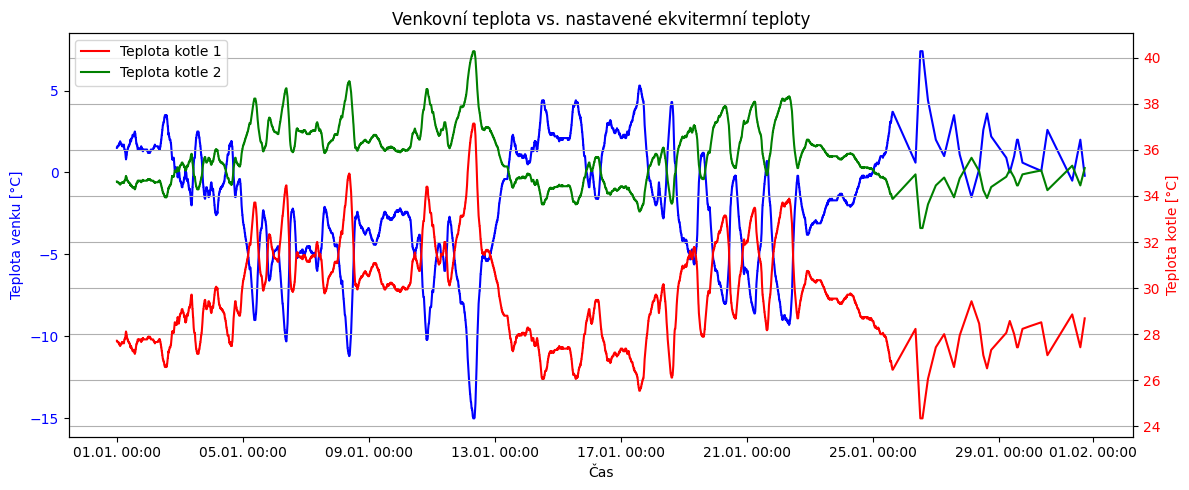

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))

# Hlavní osa
ax = plt.gca()

# Venkovní teplota
ax.plot(df_netatmo["time_local"], df_netatmo["temperature"], color="blue")
ax.set_ylabel("Teplota venku [°C]", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

# Vedlejší osa (Boiler_water)
ax2 = ax.twinx()
ax2.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Teplota kotle 1")
ax2.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Teplota kotle 2")

ax2.set_ylabel("Teplota kotle [°C]", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Titulek a popisky
plt.title("Venkovní teplota vs. nastavené ekvitermní teploty")
ax.set_xlabel("Čas")

# Formátování osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

# Legenda pro vedlejší osu
ax2.legend(loc="upper left")

plt.grid(True)
plt.tight_layout()
plt.show()


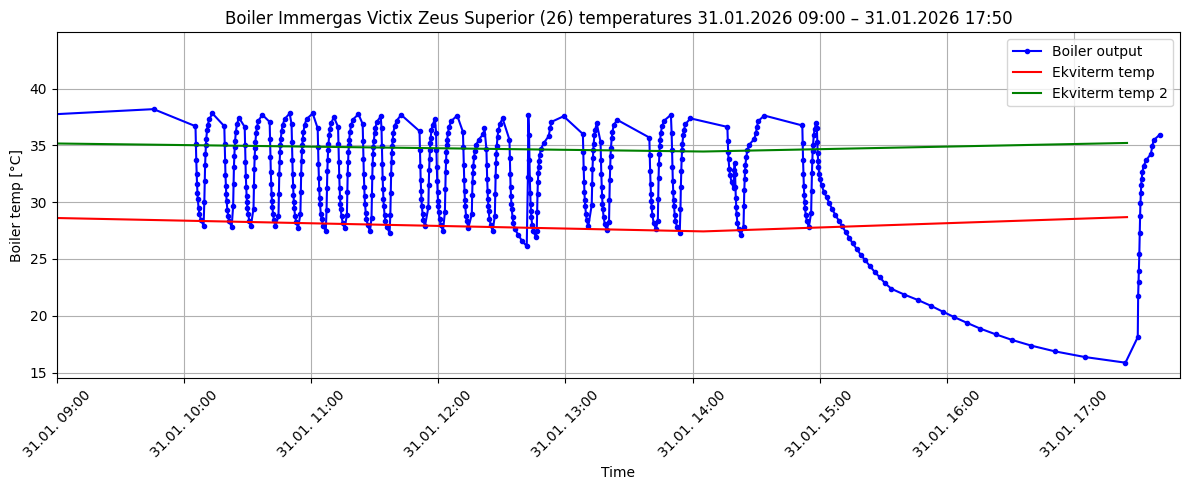

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-01-31 9:00:00")
end_time   = pd.Timestamp("2026-01-31 17:50")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df["Time"], df["Value"], marker=".", color="blue", label="Boiler output")

# Netatmo – původní křivka
ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")

# Netatmo – nová křivka (Boiler_water_2)
ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")

# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



/var/folders/px/7v29qw4j1fq7r7dx3wzzggyr0000gn/T/ipykernel_11555/3204442714.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")


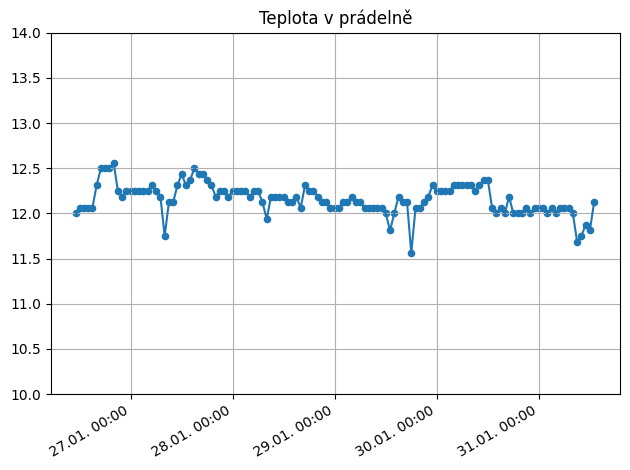

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_pradelna = pd.read_csv("teplota_pradelna.csv", header=None, names=["cas", "tepl"])
df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")
df_pradelna["tepl"] = pd.to_numeric(df_pradelna["tepl"], errors="coerce")
df_pradelna = df_pradelna.dropna().sort_values("cas").drop_duplicates("cas")

fig, ax = plt.subplots()

ax.set_ylim(10, 14)
ax.set_title("Teplota v prádelně")

ax.plot(df_pradelna["cas"], df_pradelna["tepl"])
ax.scatter(df_pradelna["cas"], df_pradelna["tepl"], s=20)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()




In [38]:
df_pradelna

,cas,tepl
1,2026-01-26 11:15:44,12.000
2,2026-01-26 12:00:03,12.062
3,2026-01-26 13:00:03,12.062
4,2026-01-26 14:00:03,12.062
5,2026-01-26 15:00:03,12.062
...,...,...
119,2026-01-31 09:00:03,11.687
120,2026-01-31 10:00:03,11.750
121,2026-01-31 11:00:03,11.875
122,2026-01-31 12:00:03,11.812
